# Vision Transformer Attention Visualization Tutorial

This tutorial demonstrates how to visualize attention maps from a trained Vision Transformer (ViT) model. You'll learn how to extract attention weights from different attention heads and overlay them on input images to understand what the model is "looking at" when making predictions.

## Prerequisites

Before starting this tutorial, make sure you have:
- A trained Vision Transformer model (saved as `VisionTransformer.pt`)
- PyTorch installed with MPS support (for Apple Silicon Macs) or CUDA
- The required Python packages (see requirements.txt)
- CIFAR-10 dataset downloaded

## Setup and Imports

First, let's set up our environment and import the necessary libraries:

In [1]:
import sys, os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
sys.path.append(str(Path(os.getcwd()).parent))
from network import VisionTransformer, CNN

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
net = VisionTransformer.load("../saved/VisionTransformer.pt")

## Preparing the Input Data

We'll use the CIFAR-10 test dataset to visualize attention maps. This section shows how to:
1. Load and preprocess the data
2. Apply the same transformations used during training
3. Display a batch of images


**Key Points**:
- The normalization `(0.5, 0.5, 0.5)` centers the pixel values around 0
- We denormalize by multiplying by 0.5 and adding 0.5 for display
- The batch size of 8 allows us to visualize multiple images simultaneously

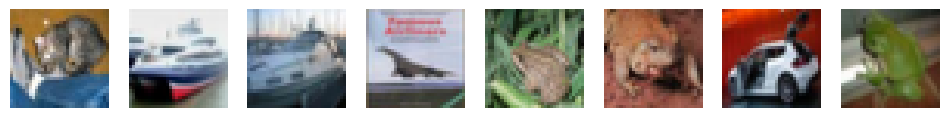

In [2]:
# Define the same transform used during training
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR10 test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='../data', 
    train=False,
    download=True,
    transform=transform
)

# Get a batch of images
batch_size = 8
indices = range(batch_size)
images = []
labels = []
for i in indices:
    image, label = test_dataset[i]
    images.append(image)
    labels.append(label)
images = torch.stack(images)  # Stack into batch (B,C,H,W)
labels = torch.tensor(labels)

# Display the images in a grid
fig, axes = plt.subplots(1, batch_size, figsize=(12, 3))
for i in range(batch_size):
    axes[i].imshow(images[i].permute(1,2,0).numpy() * 0.5 + 0.5)  # Denormalize for display
    axes[i].axis('off')
plt.show()


## Extracting Attention Maps

This is the core of the tutorial. We'll extract attention weights from the first transformer block and visualize how the CLS token attends to different image patches.

**Understanding the Code**:
- `attn_weights[:, 0, 1:]`: Extract attention weights where the CLS token (position 0) attends to all patches (positions 1 and beyond)
- `reshape(-1, 8, 8)`: Reshape to 8x8 grid (CIFAR-10 images are 32x32, divided into 8x8 patches)
- `F.interpolate`: Upsample the 8x8 attention map to 32x32 for pixel-level visualization

In [3]:
import torch.nn.functional as F
import torch

out = net(images)
block = net.blocks[0]

attn_maps = []
for i in range(len(block.attention.attention_heads)):
    # our attention map is based on the cls token relative to each patch
    attn_weights = block.attention.attention_heads[i].attention_weights.detach().cpu()
    cls_attn = attn_weights[:, 0, 1:].reshape(-1, 8, 8).unsqueeze(0)

    # map the attention (path-level) back to the original image (pixel-level)
    upsampled_attn = F.interpolate(cls_attn, size=(32, 32), mode='bilinear', align_corners=False)
    attn_map = upsampled_attn.squeeze().numpy()
    attn_maps.append(attn_map)

attn_maps = np.array(attn_maps)
attn_maps.shape


(4, 8, 32, 32)

## Visualizing Attention Maps

Now let's create a comprehensive visualization that shows:
1. Original images in the top row
2. Attention maps from each head overlaid on the images

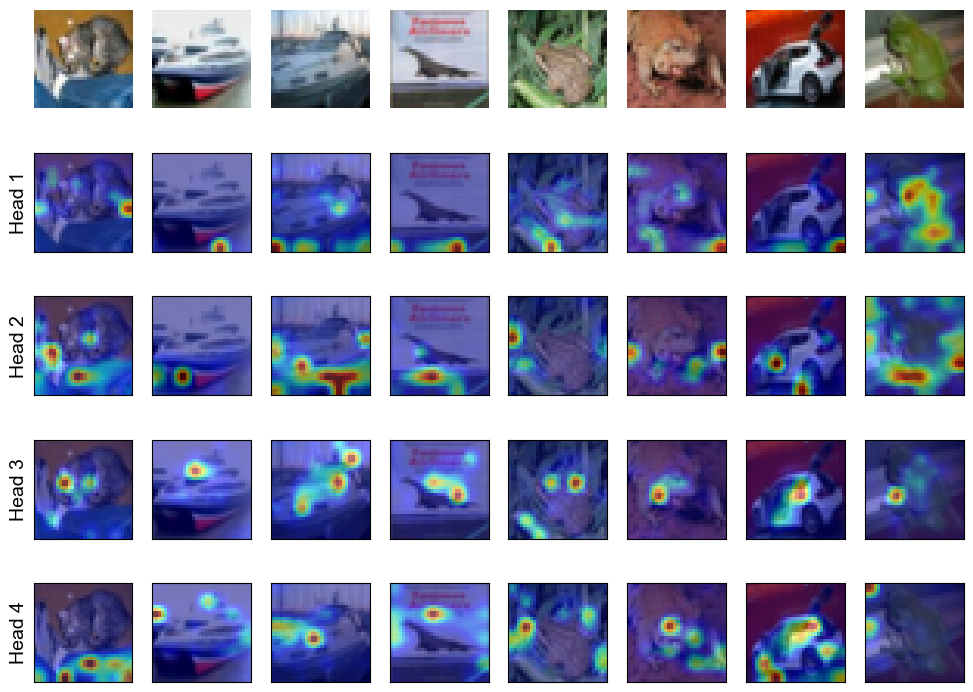

In [14]:
import matplotlib.pyplot as plt
def overlay_attention(ax, img, attn_map, alpha=0.5):
    ax.imshow(img.permute(1,2,0) * 0.5 + 0.5)  # assume img is (C,H,W), values [0,1]
    ax.imshow(attn_map, cmap="jet", alpha=alpha)
    ax.set_xticks([])
    ax.set_yticks([])


fig, axes = plt.subplots(len(attn_maps) + 1, batch_size, figsize=(12, 2 * len(attn_maps) + 1))
for i in range(batch_size):
    axes[0, i].imshow(images[i].permute(1,2,0) * 0.5 + 0.5)
    axes[0, i].axis('off')
    
    for j in range(len(attn_maps)):
        overlay_attention(axes[j+1, i], images[i], attn_maps[j, i], alpha = 0.5)
        if i == 0:  # Only add labels for first column
            axes[j+1, 0].set_ylabel(f'Head {j + 1}', fontsize=14, fontname='Arial')

plt.savefig("../figures/attention_maps.png")
plt.show()


## Interpreting the Results

The visualization reveals several important insights:

1. **Multi-head Attention**: Each attention head learns to focus on different aspects of the image
2. **CLS Token Behavior**: The CLS token (classification token) learns to attend to the most relevant parts of the image for classification
3. **Attention Patterns**: Some heads may focus on edges, others on textures, and some on semantic features